In [1]:
print("Hello world !!")

Hello world !!


In [2]:
!ls

drive  sample_data


In [3]:
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import cv2 as cv

In [4]:
!unzip -q "./drive/MyDrive/Sandbox/CarNumberPlates/blurred_images.zip" -d "./Dataset"

In [5]:
!unzip -q "./drive/MyDrive/Sandbox/CarNumberPlates/images.zip" -d "./Dataset"

In [6]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [22]:
class SandboxDataset(Dataset):
  def __init__(self, transform=None):
    self.dataroot = "./Dataset"
    self.images = os.listdir("./Dataset/images")
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = self.images[idx]
    input_path = read_image(f'{self.dataroot}/images/{img_path}') / 255
    output_path = read_image(f'{self.dataroot}/{img_path}') / 255

    if self.transform:
      input_path = self.transform(input_path)
      output_path = self.transform(output_path)

    alpha_channel = torch.ones(1,150,150)

    if input_path.shape[0] == 3:
      input_path = torch.cat((input_path, alpha_channel), dim=0)

    if output_path.shape[0] == 3:
      output_path = torch.cat((output_path, alpha_channel), dim=0)

    # if input_path.shape[0] == 4:
    #   input_path = input_path[:3,:,:]
    # if output_path.shape[0] == 4:
    #   output_path = output_path[:3,:,:]

    return input_path, output_path

In [23]:
transform = transforms.Compose([transforms.Resize((150,150), antialias=False)])
dataset = SandboxDataset(transform=transform)

train_set, test_set = random_split(dataset, [0.8,0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

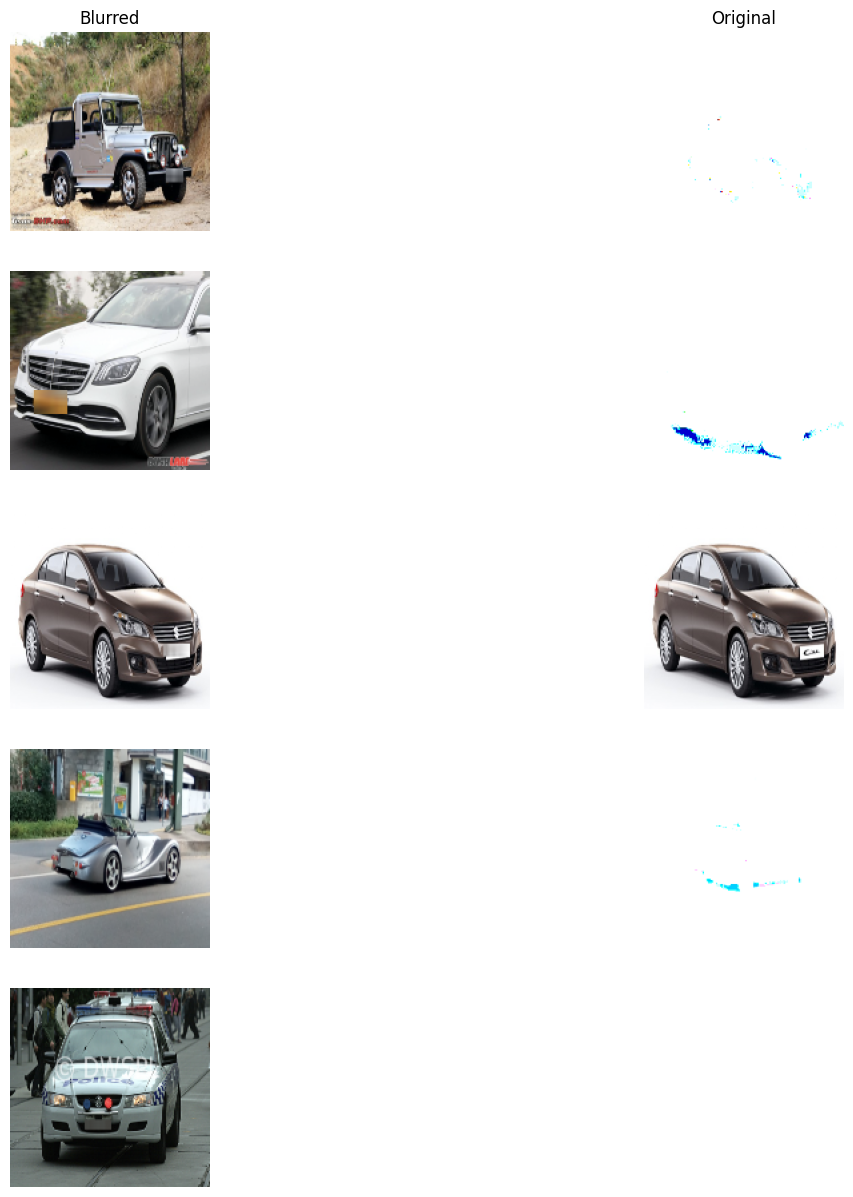

In [24]:
# Visualise Dataset

def show_images(original,blurred):
  fig, axs = plt.subplots(5,2,figsize=(15,15))
  axs[0,0].set_title('Blurred')
  axs[0,1].set_title('Original')

  for i in range(5):
    axs[i,0].imshow(blurred[i].permute(1,2,0))
    axs[i,0].axis('off')
    axs[i,1].imshow(original[i].permute(1,2,0))
    axs[i,1].axis('off')
  plt.show()

original, blurred = next(iter(trainloader))
show_images(original, blurred)

In [25]:
EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [26]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.down1 = nn.Conv2d(4, 64, 3, stride=2)
    self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
    self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)

    self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
    self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
    self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
    self.up4 = nn.ConvTranspose2d(128, 4, 3, stride=2, output_padding=1)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    d1 = self.relu(self.down1(x))
    d2 = self.relu(self.down2(d1))
    d3 = self.relu(self.down3(d2))
    d4 = self.relu(self.down4(d3))

    u1 = self.relu(self.up1(d4))
    u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
    u3 = self.relu(self.up3(torch.cat((u2,d2), dim=1)))
    u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

    return u4



In [27]:
model = AutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: ",total_params)

Total number of parameters:  3473540


In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
for epoch in range(EPOCHS):
  running_loss = 0.0

  for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
    color_img = color_img.to(DEVICE)
    gray_img = gray_img.to(DEVICE)

    predictions = model(gray_img)

    optimizer.zero_grad()
    loss = criterion(color_img, predictions)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'Epoch: {epoch+1}, Loss: {running_loss:.6f}')

  0%|          | 0/9 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[32, 3, 150, 150] to have 4 channels, but got 3 channels instead

In [21]:
# print(len(os.listdir("./Dataset/images")))
num3 = 0
num4 = 0
for idx in range(1,346):
  img_path = os.listdir("./Dataset/images")[idx]
  input_path = read_image(f'{"./Dataset"}/images/{img_path}') / 255
  output_path = read_image(f'{"./Dataset"}/{img_path}') / 255

  print("input:",input_path.shape)
  print("output:",output_path.shape)
  print()

  if input_path.shape[0] == 3:
    num3 += 1
  elif input_path.shape[0] == 4:
    num4 += 1

print(num3)
print(num4)

input: torch.Size([4, 307, 400])
output: torch.Size([3, 307, 400])

input: torch.Size([3, 350, 590])
output: torch.Size([3, 350, 590])

input: torch.Size([4, 300, 400])
output: torch.Size([3, 300, 400])

input: torch.Size([4, 225, 400])
output: torch.Size([3, 225, 400])

input: torch.Size([4, 253, 400])
output: torch.Size([3, 253, 400])

input: torch.Size([4, 215, 400])
output: torch.Size([3, 215, 400])

input: torch.Size([3, 300, 400])
output: torch.Size([3, 300, 400])

input: torch.Size([4, 267, 400])
output: torch.Size([3, 267, 400])

input: torch.Size([4, 267, 400])
output: torch.Size([3, 267, 400])

input: torch.Size([3, 262, 508])
output: torch.Size([3, 262, 508])

input: torch.Size([4, 232, 500])
output: torch.Size([3, 232, 500])

input: torch.Size([3, 360, 480])
output: torch.Size([3, 360, 480])

input: torch.Size([3, 450, 600])
output: torch.Size([3, 450, 600])

input: torch.Size([4, 225, 400])
output: torch.Size([3, 225, 400])

input: torch.Size([3, 400, 500])
output: torch.S